# Generate multiomic AnnData for scRNA-seq and CITE-seq

## Descrption

Last updated: 06/13/2022

This notebook is to add the ADT AnnData in addition to AnnData from RNA.
Notes.
- the metadata part is the same for adata.obs[], thus we could just use either of them (or use the merge='same')
- we'd like to combine "cell x gene" matrix to "cell x protein", to create "cell x (gene+protein)".
- We do not want to change the embeddings (PCA, UMAP, etc.) that was already computed, as we just want to overlay on top.
- 

Note on 06/13/2022
- The counts data in adata_RNA was "scaled", thus we will recover the "raw counts" here.
- The counts data in adata_ADT was actually "raw". This might explain why we saw such a huge difference between RNA and ADT.

Strategy:
1) Recover the raw counts for RNA (and check ADT)
2) Re-merge the RNA and ADT for a combined anndata
3) Save the adata, transfer the annotations from MK's version to this adata.

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy as sp

import os

In [10]:
# file path
filepath = '/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/RNA_Seq_data/merged_SCG1_10_Biopsies/'

RNA_dataname = 'biopsies_annotated_RNA'
ADT_dataname = 'biopsies_annotated_ADT'
dataformat = '.h5ad'

adata_RNA = sc.read(filepath+RNA_dataname+dataformat)
adata_ADT = sc.read(filepath+ADT_dataname+dataformat)

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [11]:
adata_RNA

AnnData object with n_obs × n_vars = 93900 × 28638
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'SAMPLE.by.SNPs', 'nCount_SCT', 'nFeature_SCT', 'DF.DROPLET.TYPE', 'LIBRARY', 'nCount_ADT', 'nFeature_ADT', 'RNA_snn_res.0.2', 'seurat_clusters', 'louvain_res0.2', 'RNA_snn_res.0.4', 'louvain_res0.4', 'RNA_snn_res.0.6', 'louvain_res0.6', 'RNA_snn_res.0.8', 'louvain_res0.8', 'RNA_snn_res.1', 'louvain_res1', 'RNA_snn_res.1.2', 'louvain_res1.2', 'RNA_snn_res.1.4', 'louvain_res1.4', 'RNA_snn_res.1.6', 'louvain_res1.6', 'RNA_snn_res.1.8', 'louvain_res1.8', 'RNA_snn_res.2', 'louvain_res2', 'CoLabs_ID', 'CoLabs_patient', 'colon_biopsy', 'condition', 'LIBRARY.TYPE', 'coarse_annotations', 'CoLabs_sample', 'BIOS_ID', 'Endoscopic_Severity', 'patient_short', 'a4b7', 'fine_annotations'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.

In [12]:
# Check the counts (raw, log-norm, etc.)
np.sum(adata_RNA.X.todense(),1)

matrix([[ 700.],
        [1974.],
        [ 270.],
        ...,
        [1995.],
        [6917.],
        [2073.]])

In [13]:
adata_ADT

AnnData object with n_obs × n_vars = 93900 × 177
    obs: 'orig.ident', 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'SAMPLE.by.SNPs', 'nCount_SCT', 'nFeature_SCT', 'DF.DROPLET.TYPE', 'LIBRARY', 'RNA_snn_res.0.2', 'seurat_clusters', 'louvain_res0.2', 'RNA_snn_res.0.4', 'louvain_res0.4', 'RNA_snn_res.0.6', 'louvain_res0.6', 'RNA_snn_res.0.8', 'louvain_res0.8', 'RNA_snn_res.1', 'louvain_res1', 'RNA_snn_res.1.2', 'louvain_res1.2', 'RNA_snn_res.1.4', 'louvain_res1.4', 'RNA_snn_res.1.6', 'louvain_res1.6', 'RNA_snn_res.1.8', 'louvain_res1.8', 'RNA_snn_res.2', 'louvain_res2', 'CoLabs_ID', 'CoLabs_patient', 'colon_biopsy', 'condition', 'LIBRARY.TYPE', 'coarse_annotations', 'CoLabs_sample', 'BIOS_ID', 'Endoscopic_Severity', 'patient_short', 'a4b7', 'fine_annotations'
    var: 'features'

In [14]:
# Check the counts (raw, log-norm, etc.)
np.sum(adata_ADT.X.todense(),1)

matrix([[   0.],
        [   0.],
        [   0.],
        ...,
        [1039.],
        [ 668.],
        [ 723.]])

In [15]:
adata_RNA.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,NUM.SNPS,NUM.READS,DROPLET.TYPE,BEST.GUESS,percent.mt,percent.ribo,S.Score,...,colon_biopsy,condition,LIBRARY.TYPE,coarse_annotations,CoLabs_sample,BIOS_ID,Endoscopic_Severity,patient_short,a4b7,fine_annotations
AAACCCAAGTGGACTG-1_1,XAUT1-POOL-SCG1,700.0,160,25,25,SNG,"0,0",1.714286,4.142857,-0.003922,...,L,UCNB,GEX_only,2,XAUT1-HS8-CLL1,13736,1,HS8,a4-/b7-,NOT CONSIDERED
AAACCCACACGCACCA-1_1,XAUT1-POOL-SCG1,1974.0,762,198,212,SNG,"6,6",33.417722,12.202532,-0.011765,...,L,HC,GEX_only,4,XAUT1-HS4-CLL1,13672,0,HS4,a4-/b7-,MES.S1
AAACCCACATAGTCAC-1_1,XAUT1-POOL-SCG1,270.0,189,46,49,SNG,"3,3",22.962963,9.629630,-0.011765,...,R,UCV,GEX_only,4,XAUT1-HS11-CLR1,13497,0,HS11,a4-/b7-,MES.Pericyte
AAACCCAGTGTTCAGT-1_1,XAUT1-POOL-SCG1,1430.0,800,199,227,SNG,"1,1",3.986014,13.496503,-0.019608,...,R,UCV,GEX_only,0,XAUT1-HS9-CLR1,13314,0,HS9,a4-/b7-,T.CD4+ Naive
AAACCCATCAGCCCAG-1_1,XAUT1-POOL-SCG1,1931.0,979,251,336,SNG,"5,5",7.509063,19.316416,-0.019608,...,R,HC,GEX_only,1,XAUT1-HS1-CLR1,13417,0,HS1,a4-/b7-,T.CD8+ Resident Memory


In [16]:
RNA_var_names = adata_RNA.var_names
RNA_var_names.tolist()
#RNA_var_names

['RP11-34P13.7',
 'CICP27',
 'RP11-34P13.15',
 'RP11-34P13.13',
 'FO538757.1',
 'AP006222.2',
 'RP4-669L17.10',
 'MTND1P23',
 'MTND2P28',
 'MTCO1P12',
 'MTCO2P12',
 'MTATP6P1',
 'MTCO3P12',
 'RP11-206L10.2',
 'RP11-206L10.9',
 'RP11-206L10.8',
 'FAM87B',
 'LINC01128',
 'LINC00115',
 'FAM41C',
 'RP11-54O7.1',
 'RP11-54O7.3',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'RP11-54O7.17',
 'HES4',
 'ISG15',
 'AGRN',
 'RP11-465B22.3',
 'RP11-54O7.18',
 'RNF223',
 'C1orf159',
 'LINC01342',
 'RP11-465B22.8',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'FAM132A',
 'RP5-902P8.12',
 'UBE2J2',
 'RP5-902P8.10',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'CPSF3L',
 'RP5-890O3.9',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'NDUFB4P8',
 'CCNL2',
 'RP4-758J18.2',
 'MRPL20',
 'RP4-758J18.13',
 'ANKRD65',
 'RP4-758J18.10',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'RP5-832C2.5',
 'FNDC10',
 'RP11-345P4.9',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'RP11-345P4.10',
 'SL

In [17]:
ADT_var_names = adata_ADT.var_names
ADT_var_names.tolist()
#ADT_var_names

['B7-H4',
 'C5L2',
 'CD10',
 'CD102',
 'CD103',
 'CD105',
 'CD107a--LAMP-1',
 'CD112--Nectin-2',
 'CD115--CSF-1R',
 'CD117--c-kit',
 'CD119--IFN-G-R-A-chain',
 'CD11b',
 'CD11c',
 'CD120b',
 'CD123',
 'CD127--IL-7Ra',
 'CD134--OX40',
 'CD135',
 'CD137',
 'CD137L--4-1BB-Ligand',
 'CD138--Syndecan-1',
 'CD14.2',
 'CD140a',
 'CD140b',
 'CD141--Thrombomodulin',
 'CD144--VE-cadherin',
 'CD146',
 'CD15--BEA-1',
 'CD152',
 'CD154',
 'CD155--PVR',
 'CD158--KIR2DL1--KIR2DS1--KIR2DS3--KIR2DS5',
 'CD158b--KIR2DL2--KIR2DL3--NKAT2',
 'CD158e1--KIR3DL1--NKB1',
 'CD158f--KIR2DL5',
 'CD16',
 'CD161',
 'CD163.1',
 'CD169--Sialoadhesin--Siglec-1',
 'CD172a--SIRPa',
 'CD178--FasL',
 'CD18',
 'CD183--CXCR3',
 'CD184--CXCR4',
 'CD185--CXCR5',
 'CD186--CXCR6',
 'CD19.1',
 'CD192--CCR2',
 'CD193--CCR3',
 'CD194--CCR4',
 'CD195--CCR5',
 'CD196--CCR6',
 'CD197--CCR7',
 'CD1a',
 'CD1c',
 'CD1d',
 'CD2.1',
 'CD20',
 'CD202b--Tie2--Tek',
 'CD21',
 'CD22.1',
 'CD223--LAG-3',
 'CD226--DNAM-1.1',
 'CD23',
 'CD24.1',

In [18]:
RNA_ADT_var_names = RNA_var_names.tolist() + ADT_var_names.tolist()
RNA_ADT_var_names

['RP11-34P13.7',
 'CICP27',
 'RP11-34P13.15',
 'RP11-34P13.13',
 'FO538757.1',
 'AP006222.2',
 'RP4-669L17.10',
 'MTND1P23',
 'MTND2P28',
 'MTCO1P12',
 'MTCO2P12',
 'MTATP6P1',
 'MTCO3P12',
 'RP11-206L10.2',
 'RP11-206L10.9',
 'RP11-206L10.8',
 'FAM87B',
 'LINC01128',
 'LINC00115',
 'FAM41C',
 'RP11-54O7.1',
 'RP11-54O7.3',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'RP11-54O7.17',
 'HES4',
 'ISG15',
 'AGRN',
 'RP11-465B22.3',
 'RP11-54O7.18',
 'RNF223',
 'C1orf159',
 'LINC01342',
 'RP11-465B22.8',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'FAM132A',
 'RP5-902P8.12',
 'UBE2J2',
 'RP5-902P8.10',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'CPSF3L',
 'RP5-890O3.9',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'NDUFB4P8',
 'CCNL2',
 'RP4-758J18.2',
 'MRPL20',
 'RP4-758J18.13',
 'ANKRD65',
 'RP4-758J18.10',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'RP5-832C2.5',
 'FNDC10',
 'RP11-345P4.9',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'RP11-345P4.10',
 'SL

### Concatenate the 'cell x gene' matrix with 'cell x protein' for one AnnData object

In [19]:
# Put the assay name for adata.var just in case we need to differentiate where the marker comes from (usually it shoudl be obvious!)
adata_RNA.var['assay'] = 'RNA'
adata_ADT.var['assay'] = 'ADT'

adata = ad.concat([adata_RNA, adata_ADT], axis=1, merge="first")

In [20]:
adata

AnnData object with n_obs × n_vars = 93900 × 28815
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'SAMPLE.by.SNPs', 'nCount_SCT', 'nFeature_SCT', 'DF.DROPLET.TYPE', 'LIBRARY', 'nCount_ADT', 'nFeature_ADT', 'RNA_snn_res.0.2', 'seurat_clusters', 'louvain_res0.2', 'RNA_snn_res.0.4', 'louvain_res0.4', 'RNA_snn_res.0.6', 'louvain_res0.6', 'RNA_snn_res.0.8', 'louvain_res0.8', 'RNA_snn_res.1', 'louvain_res1', 'RNA_snn_res.1.2', 'louvain_res1.2', 'RNA_snn_res.1.4', 'louvain_res1.4', 'RNA_snn_res.1.6', 'louvain_res1.6', 'RNA_snn_res.1.8', 'louvain_res1.8', 'RNA_snn_res.2', 'louvain_res2', 'CoLabs_ID', 'CoLabs_patient', 'colon_biopsy', 'condition', 'LIBRARY.TYPE', 'coarse_annotations', 'CoLabs_sample', 'BIOS_ID', 'Endoscopic_Severity', 'patient_short', 'a4b7', 'fine_annotations'
    var: 'assay'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    obsp: 'distances'

### Add back some metadata that is needed
adata.uns

In [21]:
adata.uns = adata_RNA.uns

In [92]:
# This shouln't work as the shape is different now (cell x (gene+protein))
#adata.varm = adata_RNA.varm


In [23]:
adata.obs['fine_annotations'].unique()

array(['NOT CONSIDERED', 'MES.S1', 'MES.Pericyte', 'T.CD4+ Naive',
       'T.CD8+ Resident Memory', 'T.CD8+ Effector', 'B.Memory',
       'T.CD4+ Resident Memory', 'T.CD8-/CD4- Gamma Deltas',
       'EPI.Undifferentiated 1', 'B.Naive 2', 'MYE.MoMacDC', 'B.Naive 1',
       'EPI.Undifferentiated 2', 'MYE.Monocytes', 'ENDO.Venous',
       'EPI.Cycling Undifferentiated', 'MES.MF', 'B.Cycling Memory',
       'MES.S2', 'ENDO.Blood Endothelial', 'EPI.Enterocytes', 'MES.S3',
       'MES.Activated Fibroblasts', 'MYE.DCs', 'T.CD4+ Tregs',
       'EPI.Goblet', 'MYE.Macrophages', 'ENDO.Mesenchymal',
       'ENDO.Arterial', 'MYE.pDCs', 'EPI.EECs', 'B.Cycling Plasmablasts',
       'EPI.BEST4/OTOP2 Cells', 'ENDO.Lymphatic'], dtype=object)

## Converting continuous data to categorical in AnnData

We need to convert some "continuous" fields to "categorial" such that we can load this h5ad object into the Cellxgene.

In this example of UC datasets, we have clusters (louvain_resXX, and seurat_clusters) and the annotated clusters (coarse_annotations, fine_annotations). Additionally, we have certain categorical variables such as, condition, CoLabs_ID, CoLabs_patient, Library, orig.ident, etc.)

In [25]:
# First, extract all keys from the adata.obs
obs_keys_all = adata.obs.keys()
obs_keys_all

adata.obs[obs_keys_all[0]].unique()

array(['XAUT1-POOL-SCG1', 'XAUT1-POOL-SCG10', 'XAUT1-POOL-SCG2',
       'XAUT1-POOL-SCG3', 'XAUT1-POOL-SCG4', 'XAUT1-POOL-SCG5',
       'XAUT1-POOL-SCG6', 'XAUT1-POOL-SCG7', 'XAUT1-POOL-SCG8',
       'XAUT1-POOL-SCG9'], dtype=object)

In [26]:
# Check some fields to see if they are continuous or categorical
# we can be smarter about the decision of "continuous" vs "categorical" 
# by using adata.obs['key'].unique and checking the size of this list.
list_keys_unique = []
for i in range(0,len(obs_keys_all)):
    list_keys_unique = list_keys_unique + [len(adata.obs[obs_keys_all[i]].unique())]
               
list_keys_unique = np.array(list_keys_unique)
list_keys_unique

array([   10, 12336,  3793,  1785,  2907,     1,    11, 74488, 77822,
        2483, 23225,     4,   105,  4747,  2648,     1,    10,  2949,
         164,    15,    46,    15,    19,    19,    21,    21,    27,
          27,    30,    30,    33,    33,    36,    36,    39,    39,
          45,    45,    46,    46,   105,    12,     2,     3,     2,
          14,    21,    12,     3,    12,     4,    35])

(array([0., 2., 2., 2., 2., 0., 0., 0., 0., 0., 2., 1., 3., 0., 1., 2., 0.,
        0., 0., 2., 0., 3., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 2.,
        0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80., 

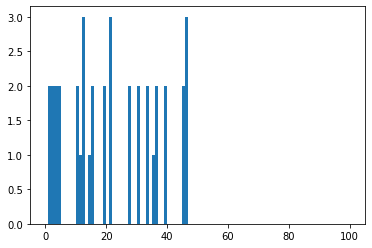

In [27]:
plt.hist(list_keys_unique,bins=100,range=(0,100))
#vertical line at threshold

From the above histogram, we can conclude that the threshold could be "100" for the number of unique values from each adata.obs['key'].unique(). 

In [28]:
# threshold for continuous vs categorical
thresh_categorical = 100

# create a list of "keys" to be converted to categorical data
key_names = obs_keys_all[list_keys_unique < thresh_categorical]
key_names

Index(['orig.ident', 'DROPLET.TYPE', 'BEST.GUESS', 'Phase', 'DF.DROPLET.TYPE',
       'LIBRARY', 'RNA_snn_res.0.2', 'seurat_clusters', 'louvain_res0.2',
       'RNA_snn_res.0.4', 'louvain_res0.4', 'RNA_snn_res.0.6',
       'louvain_res0.6', 'RNA_snn_res.0.8', 'louvain_res0.8', 'RNA_snn_res.1',
       'louvain_res1', 'RNA_snn_res.1.2', 'louvain_res1.2', 'RNA_snn_res.1.4',
       'louvain_res1.4', 'RNA_snn_res.1.6', 'louvain_res1.6',
       'RNA_snn_res.1.8', 'louvain_res1.8', 'RNA_snn_res.2', 'louvain_res2',
       'CoLabs_patient', 'colon_biopsy', 'condition', 'LIBRARY.TYPE',
       'coarse_annotations', 'CoLabs_sample', 'BIOS_ID', 'Endoscopic_Severity',
       'patient_short', 'a4b7', 'fine_annotations'],
      dtype='object')

In [29]:
# create a for loop to go through the adata.obs dataframe and convert selected keys to categorical
for i in range(0,len(key_names)):
    adata.obs[key_names[i]] = pd.Categorical(adata.obs[key_names[i]])
    


In [30]:
# save the converted data into h5ad object
adata.write_h5ad(filepath+'biopsies_annotated_allGenes_RNA_ADT'+'_categorical'+dataformat)

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'SAMPLE.by.SNPs' as categorical
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CoLabs_ID' as categorical
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a fut